# Data Processing

This notebook takes the observerd data, and the Gala simulated data, and prepares it for use in the membership process. It works in the following steps:

1. Import observed data and Gala simulated stars
2. Produce new extinction-corrected magnitudes for the observed stars
3. Truncate both datasets to the extinction-corrected completeness limit 
4. Calculate and append Galactic 'l' and 'b' coordinates to observed stars dataset
5. Export 

In [63]:
# General imports
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.patches import Circle

# Handling Gala .fits file
from astropy.io import fits

# To convert coordinates to Galactic l and b (for simulating field stars)
from astropy.coordinates import SkyCoord
import astropy.units as u

# 1. Import data

In [64]:
# Import observed data as a .csv
observed_df_raw = pd.read_csv('C:/Users/smick/Desktop/Research/data/NGC6569_gaia_withRVs.csv')
observed_df_raw = observed_df_raw.dropna(subset=['pmra', 'pmdec', 'parallax']) # we only want stars with observed motions and parallax

# Open the .fits file for the Gala simulation
with fits.open('C:/Users/smick/Desktop/Research/data/NGC6569_gala.fits') as hdul:
    gala_data = hdul[1].data
    
gala_array = np.array(gala_data) # convert to a NumPy array
gala_array = gala_array.byteswap().view(gala_array.dtype.newbyteorder('<')) # convert to little-endian format
gala_df = pd.DataFrame({name: gala_array[name] for name in gala_array.dtype.names}) # Convert array to DataFrame 

# 2. Correct for extinction

In [65]:
# Correct for extinction before truncating. This is needed to reduce the significant impact of the dust lanes on the observed star densities
observed_df_raw['gmag_extcorr'] = observed_df_raw['gmag'] - observed_df_raw['Ag']
observed_df_raw['rmag_extcorr'] = observed_df_raw['rmag'] - observed_df_raw['Ar']
observed_df_raw['imag_extcorr'] = observed_df_raw['imag'] - observed_df_raw['Ai']
observed_df_raw['zmag_extcorr'] = observed_df_raw['zmag'] - observed_df_raw['Az']


# 3. Truncate to completeness limit

If there is not an established completeness limit, use the completeness_limit notebook to find one using the observational data.

In [ ]:
# Truncating stars first to match the observed data's extinction-corrected completeness limit
observed_df_cut = observed_df_raw[(observed_df_raw['imag_extcorr'] > 9) & (observed_df_raw['imag_extcorr'] <= 18.63)]
gala_df= gala_df[(gala_df['i'] > 9) & (gala_df['i'] <= 23)] # use the full range of simulated cluster stars to create a wider spread in the CLM later on

# Check how many stars we are working with
print(f"Stars in truncated observed dataset: {len(observed_df_cut['radeg'])}")
print(f"Stars in Gala dataset: {len(gala_df['RA'])}")

Stars in truncated observed dataset: 311833
Stars in Gala dataset: 46206


# 4. Calculate Galactic 'l' and 'b' coordinates

In [67]:
# Create a SkyCoord object for observed stars. This is needed to convert in the next step.
coords = SkyCoord(ra=observed_df_cut['radeg'].values,
                  dec=observed_df_cut['decdeg'].values,
                  unit=(u.degree,u.degree),
                  frame='icrs')  

# Create new array of Galactic l and b coordinates
observed_df_cut['l'] = coords.galactic.l.wrap_at(180 * u.degree).deg  # Wrap is needed because we have stars ranging from (-1,5) in 'l'
observed_df_cut['b'] = coords.galactic.b.deg  

C:\Users\smick\AppData\Local\Temp\ipykernel_70608\866912144.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_df_cut['l'] = coords.galactic.l.wrap_at(180 * u.degree).deg  # Wrap is needed because we have stars ranging from (-1,5) in 'l'
C:\Users\smick\AppData\Local\Temp\ipykernel_70608\866912144.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  observed_df_cut['b'] = coords.galactic.b.deg


Take a quick look to make sure everything looks how we'd expect.

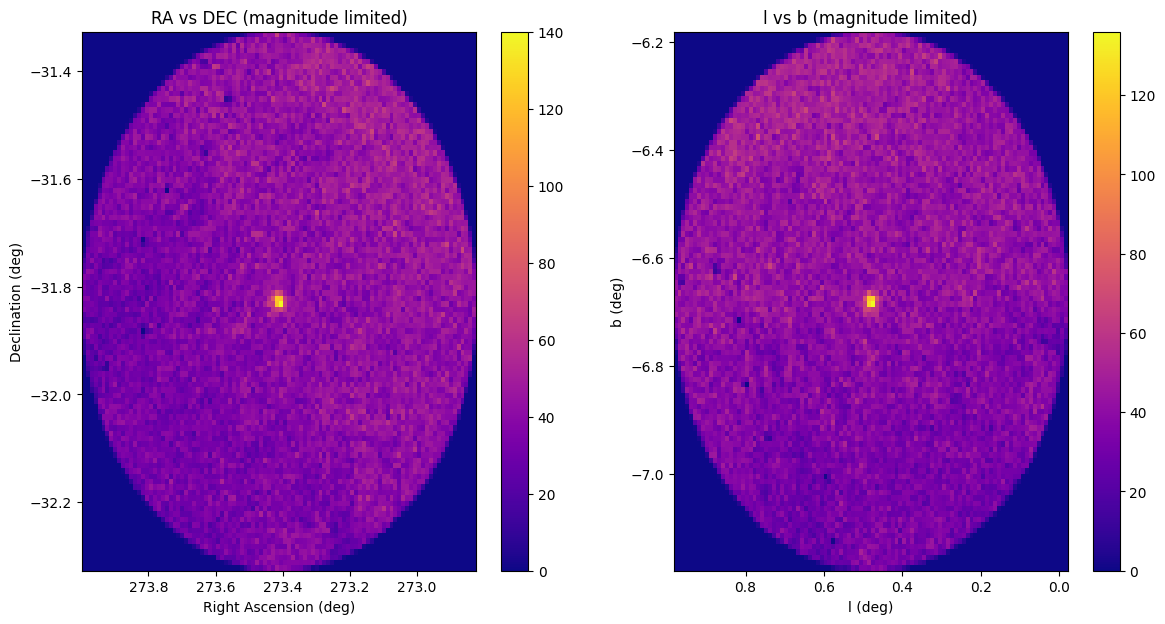

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(14, 7)) 
axs = axs.ravel()

# RA v DEC
h1 = axs[0].hist2d(
    observed_df_cut['radeg'],
    observed_df_cut['decdeg'],
    bins=100, # fine bins for visualisation, but they don't reflect the resolution of the actual process
    cmap='plasma',
)
axs[0].set_xlabel('Right Ascension (deg)')
axs[0].invert_xaxis()
axs[0].set_ylabel('Declination (deg)')
axs[0].set_title('RA vs DEC (magnitude limited)')
fig.colorbar(h1[3], ax=axs[0])

# 'l' v 'b'
h2 = axs[1].hist2d(
    observed_df_cut['l'], 
    observed_df_cut['b'], 
    bins=100, 
    cmap='plasma',
)
axs[1].set_xlabel('l (deg)')
axs[1].invert_xaxis()
axs[1].set_ylabel('b (deg)')
axs[1].set_title('l vs b (magnitude limited)')
fig.colorbar(h2[3], ax=axs[1])

# 5. Export

In [68]:
observed_df_cut.to_csv('observed_stars_mag_limited.csv', index=False)
gala_df.to_csv('gala_stars.csv')